In [1]:
import sys
sys.path.insert(0, "../kitti/")
from util_kitti import kitti_label_file_parser, kitti_calib_file_parser, get_corner_2D, set_bev_background
from util_kitti import AVG_HEIGT, AVG_WIDTH, AVG_LENTH, init_zy_plt, init_xz_plt, load_tf_image_fpn
from util_kitti import ANCHOR_Y_3D_MEAN, ANCHOR_Y_3D_STD, init_img_plt, load_tf_image, type_dict, shape_dict
from util_kitti import draw_corner_2D, draw_birdeyes, calc_iou, draw_2Dbox, KITTI_Object, gac_original_anchor_parser
from anchor_assignment_method import maxIoU

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.path import Path
import matplotlib.patches as patches

import torch
import pickle
import numpy as np 
from math import pi, atan2
import random 
import copy
import cv2

import glob
from collections import defaultdict

LABEL_DIR = "/home/lab530/KenYu/kitti/training/label_2/"
CALIB_DIR = "/home/lab530/KenYu/kitti/training/calib/"
ANCHOR_GENERATION_METHOD = "anchor_fpn" # 'anchor_fpn' 'anchors_adaptive_Yoffset' 'anchor_gac', 'anchor_adaptive', 'anchor_dense', 'BEV_anchor'
ANCHOR_ASSIGNMENT_METHOD = "maxIoU" # "maxIoU", "L1distance", "3Ddistance"
SHOW_IMAGE = ['000169', '000173', '000185', '000296', '000008'] # '000369'

if ANCHOR_GENERATION_METHOD == "anchor_gac":
    # Load GAC's anchor
    anchor_2D, anchor_3D, anchor_mask, anchors = gac_original_anchor_parser("/home/lab530/KenYu/visualDet3D/anchor/max_occlusion_2_anchor.pkl", is_transform = True)
    
    # Convert to anchors_tensor
    anchors_tensor = []
    for a in anchors:
        # anchors_tensor = [x1, y1, x2, y2, 0, cx, cy, cz, w, h, l, alpha, x3d, y3d, z3d, rot_y]
        #                   0   1   2   3   4  5   6   7   8  9  10 11     12   13   14   15
        anchors_tensor.append([a.xmin, a.ymin, a.xmax, a.ymax, 0, a.cx, a.cy, a.cz, a.w, a.h, a.l, a.alpha, a.x3d, a.y3d, a.z3d, a.rot_y])
    anchors_tensor = torch.FloatTensor(anchors_tensor)

elif ANCHOR_GENERATION_METHOD == "anchor_adaptive":
    # Load adaptive anchor
    with open("/home/lab530/KenYu/ml_toolkit/anchor_generation/pkl/anchors_adaptive.pkl", 'rb') as f:
        anchors_tensor = pickle.load(f)
    
    # Get anchors objects
    anchors = []
    for a in anchors_tensor:
        # anchors_tensor = [x1, y1, x2, y2, 0, cx, cy, cz, w, h, l, alpha, x3d, y3d, z3d, rot_y]
        #                   0   1   2   3   4  5   6   7   8  9  10 11     12   13   14   15
        #'category, truncated, occluded, alpha, xmin, ymin, xmax, ymax, height, width, length, x3d, y3d, z3d, rot_y, score]
        # 0         1          2         3      4     5     6     7     8       9      10      11   12   13   14     15
        str_line = f"Car NA NA {a[11]} {a[0]} {a[1]} {a[2]} {a[3]} {a[9]} {a[8]} {a[10]} {a[12]} {a[13]} {a[14]} {a[15]} NA"
        anchors.append( KITTI_Object(str_line, is_transform = True) )

elif ANCHOR_GENERATION_METHOD == "anchors_adaptive_Yoffset":
    # Load adaptive anchor
    with open("/home/lab530/KenYu/ml_toolkit/anchor_generation/pkl/anchors_adaptive_Yoffset.pkl", 'rb') as f:
        anchors_tensor = pickle.load(f)
    
    # Get anchors objects
    anchors = []
    for a in anchors_tensor:
        # anchors_tensor = [x1, y1, x2, y2, 0, cx, cy, cz, w, h, l, alpha, x3d, y3d, z3d, rot_y]
        #                   0   1   2   3   4  5   6   7   8  9  10 11     12   13   14   15
        #'category, truncated, occluded, alpha, xmin, ymin, xmax, ymax, height, width, length, x3d, y3d, z3d, rot_y, score]
        # 0         1          2         3      4     5     6     7     8       9      10      11   12   13   14     15
        str_line = f"Car NA NA {a[11]} {a[0]} {a[1]} {a[2]} {a[3]} {a[9]} {a[8]} {a[10]} {a[12]} {a[13]} {a[14]} {a[15]} NA"
        anchors.append( KITTI_Object(str_line, is_transform = True) )

elif ANCHOR_GENERATION_METHOD == "anchor_dense":
    # Load dense anchor
    with open("/home/lab530/KenYu/ml_toolkit/anchor_generation/pkl/anchors_bev_dense.pkl", "rb") as f:
        anchors_tensor = pickle.load(f)
    # print(f"anchors_tensor = {anchors_tensor.shape}") # torch.Size([28800, 16])

    # Get anchors objects
    anchors = []
    for a in anchors_tensor:
        # anchors_tensor = [x1, y1, x2, y2, 0, cx, cy, cz, w, h, l, alpha, x3d, y3d, z3d, rot_y]
        #                   0   1   2   3   4  5   6   7   8  9  10 11     12   13   14   15
        #'category, truncated, occluded, alpha, xmin, ymin, xmax, ymax, height, width, length, x3d, y3d, z3d, rot_y, score]
        # 0         1          2         3      4     5     6     7     8       9      10      11   12   13   14     15
        str_line = f"Car NA NA {a[11]} {a[0]} {a[1]} {a[2]} {a[3]} {a[9]} {a[8]} {a[10]} {a[12]} {a[13]} {a[14]} {a[15]} NA"
        anchors.append( KITTI_Object(str_line, is_transform = True) )

elif ANCHOR_GENERATION_METHOD == "anchor_fpn":
    # Load dense anchor
    with open("/home/lab530/KenYu/ml_toolkit/anchor_generation/pkl/anchors_fpn.pkl", "rb") as f:
        anchors_tensor = pickle.load(f)
    # print(f"anchors_tensor = {anchors_tensor.shape}") # torch.Size([28800, 16])

    P2 = kitti_calib_file_parser(CALIB_DIR + "000169.txt", new_shape_tf = (384, 1280))
    
    # Get anchors objects
    anchors = []
    for a in anchors_tensor:
        # anchors_tensor = [x1, y1, x2, y2, 0, cx, cy, cz, w, h, l, alpha, x3d, y3d, z3d, rot_y]
        #                   0   1   2   3   4  5   6   7   8  9  10 11     12   13   14   15
        #'category, truncated, occluded, alpha, xmin, ymin, xmax, ymax, height, width, length, x3d, y3d, z3d, rot_y, score]
        # 0         1          2         3      4     5     6     7     8       9      10      11   12   13   14     15
        str_line = f"Car NA NA {a[11]} {a[0]} {a[1]} {a[2]} {a[3]} {a[9]} {a[8]} {a[10]} {a[12]} {a[13]} {a[14]} {a[15]} NA"
        anchors.append( KITTI_Object(str_line, tf_matrix = P2) )

elif  ANCHOR_GENERATION_METHOD == "BEV_anchor":
    # Load dense anchor
    with open("/home/lab530/KenYu/ml_toolkit/anchor_generation/pkl/BEV_anchor.pkl", "rb") as f:
        anchors_tensor = pickle.load(f)
    # print(f"anchors_tensor = {anchors_tensor.shape}") # torch.Size([28800, 16])

    # Get anchors objects
    anchors = []
    for a in anchors_tensor:
        # anchors_tensor = [x1, y1, x2, y2, 0, cx, cy, cz, w, h, l, alpha, x3d, y3d, z3d, rot_y]
        #                   0   1   2   3   4  5   6   7   8  9  10 11     12   13   14   15
        #'category, truncated, occluded, alpha, xmin, ymin, xmax, ymax, height, width, length, x3d, y3d, z3d, rot_y, score]
        # 0         1          2         3      4     5     6     7     8       9      10      11   12   13   14     15
        str_line = f"Car NA NA {a[11]} {a[0]} {a[1]} {a[2]} {a[3]} {a[9]} {a[8]} {a[10]} {a[12]} {a[13]} {a[14]} {a[15]} NA"
        anchors.append( KITTI_Object(str_line, is_transform = True) )

# Load ALL labels
labels_all = []
label_dict = defaultdict(list) # {'000169': [1,3,6,8], ...}
c = 0
for fn in glob.glob(LABEL_DIR + "*.txt"):
    name = fn.split('/')[-1].split('.')[0]
    
    img_ori_h, img_ori_w, _ = shape_dict[ type_dict[name] ]
    
    P2_label = kitti_calib_file_parser(CALIB_DIR + fn.split('/')[-1], new_shape_tf = (384, 1280))
    
    for label in kitti_label_file_parser(fn, tf_matrix = P2_label):
        # filter labal via gac_original's critiria
        if label.occluded >= 2 or label.z3d <= 3 or label.category != "Car":
            continue
        else:
            # Transformation label bcuase of resizing, TODO all for fpn
            label.xmin *= 1280/img_ori_w
            label.ymin *= 384 /img_ori_h
            label.xmax *= 1280/img_ori_w
            label.ymax *= 384 /img_ori_h
            
            label_dict[label.idx_img].append(c)
            labels_all.append(label)
            c += 1

print(f"Number of total ground trues = {len(labels_all)}")
# print(f"Number of total label file = {len(label_dict)}") # 
print("=====================================")

# # Load images
# imgs_tf = []
# for img_id in SHOW_IMAGE:
#     img = load_tf_image(f"/home/lab530/KenYu/kitti/training/image_2/{img_id}.png")
#     imgs_tf.append(img)

# This for fpn
imgs_tf = []
for img_id in SHOW_IMAGE:
    img = load_tf_image_fpn(f"/home/lab530/KenYu/kitti/training/image_2/{img_id}.png")
    imgs_tf.append(img)



/home/lab530/anaconda3/envs/KenYuGAC/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Number of total ground trues = 21291


# Draw Anchor Assignment result 

n_pos = 209
pos_inds = tensor([ 55370,  55371,  56170,  56171,  72686,  72687,  72688,  72689,  72690,
         72691,  72692,  72700,  72701,  72702,  72703,  72704,  72705,  72819,
         72820,  72833,  72834,  72835,  72836,  72837,  72838,  72847,  72848,
         73946,  73947,  73948,  73949,  73950,  73951,  87712,  87720,  87721,
         87722,  87723,  87728,  87729,  87730,  87731,  87732,  87737,  87744,
         87745,  87752,  87753,  87754,  87755,  87760,  87761,  87762,  87763,
         87764,  87769,  87770,  87785,  87786,  87787,  87793,  87794,  87795,
         87796,  87975,  88007,  88236,  88237,  88268,  88269,  88270,  88271,
         88279,  88301,  88302,  88303,  88311,  88333,  88334,  88335,  89904,
        100181, 100237, 100238, 100239, 100285, 100286, 100287, 100292, 100293,
        100294, 100295, 100341, 100342, 100343, 100348, 100349, 100350, 100351,
        100390, 100397, 100398, 100404, 100405, 100406, 100446, 100453, 100454,
        100460, 1

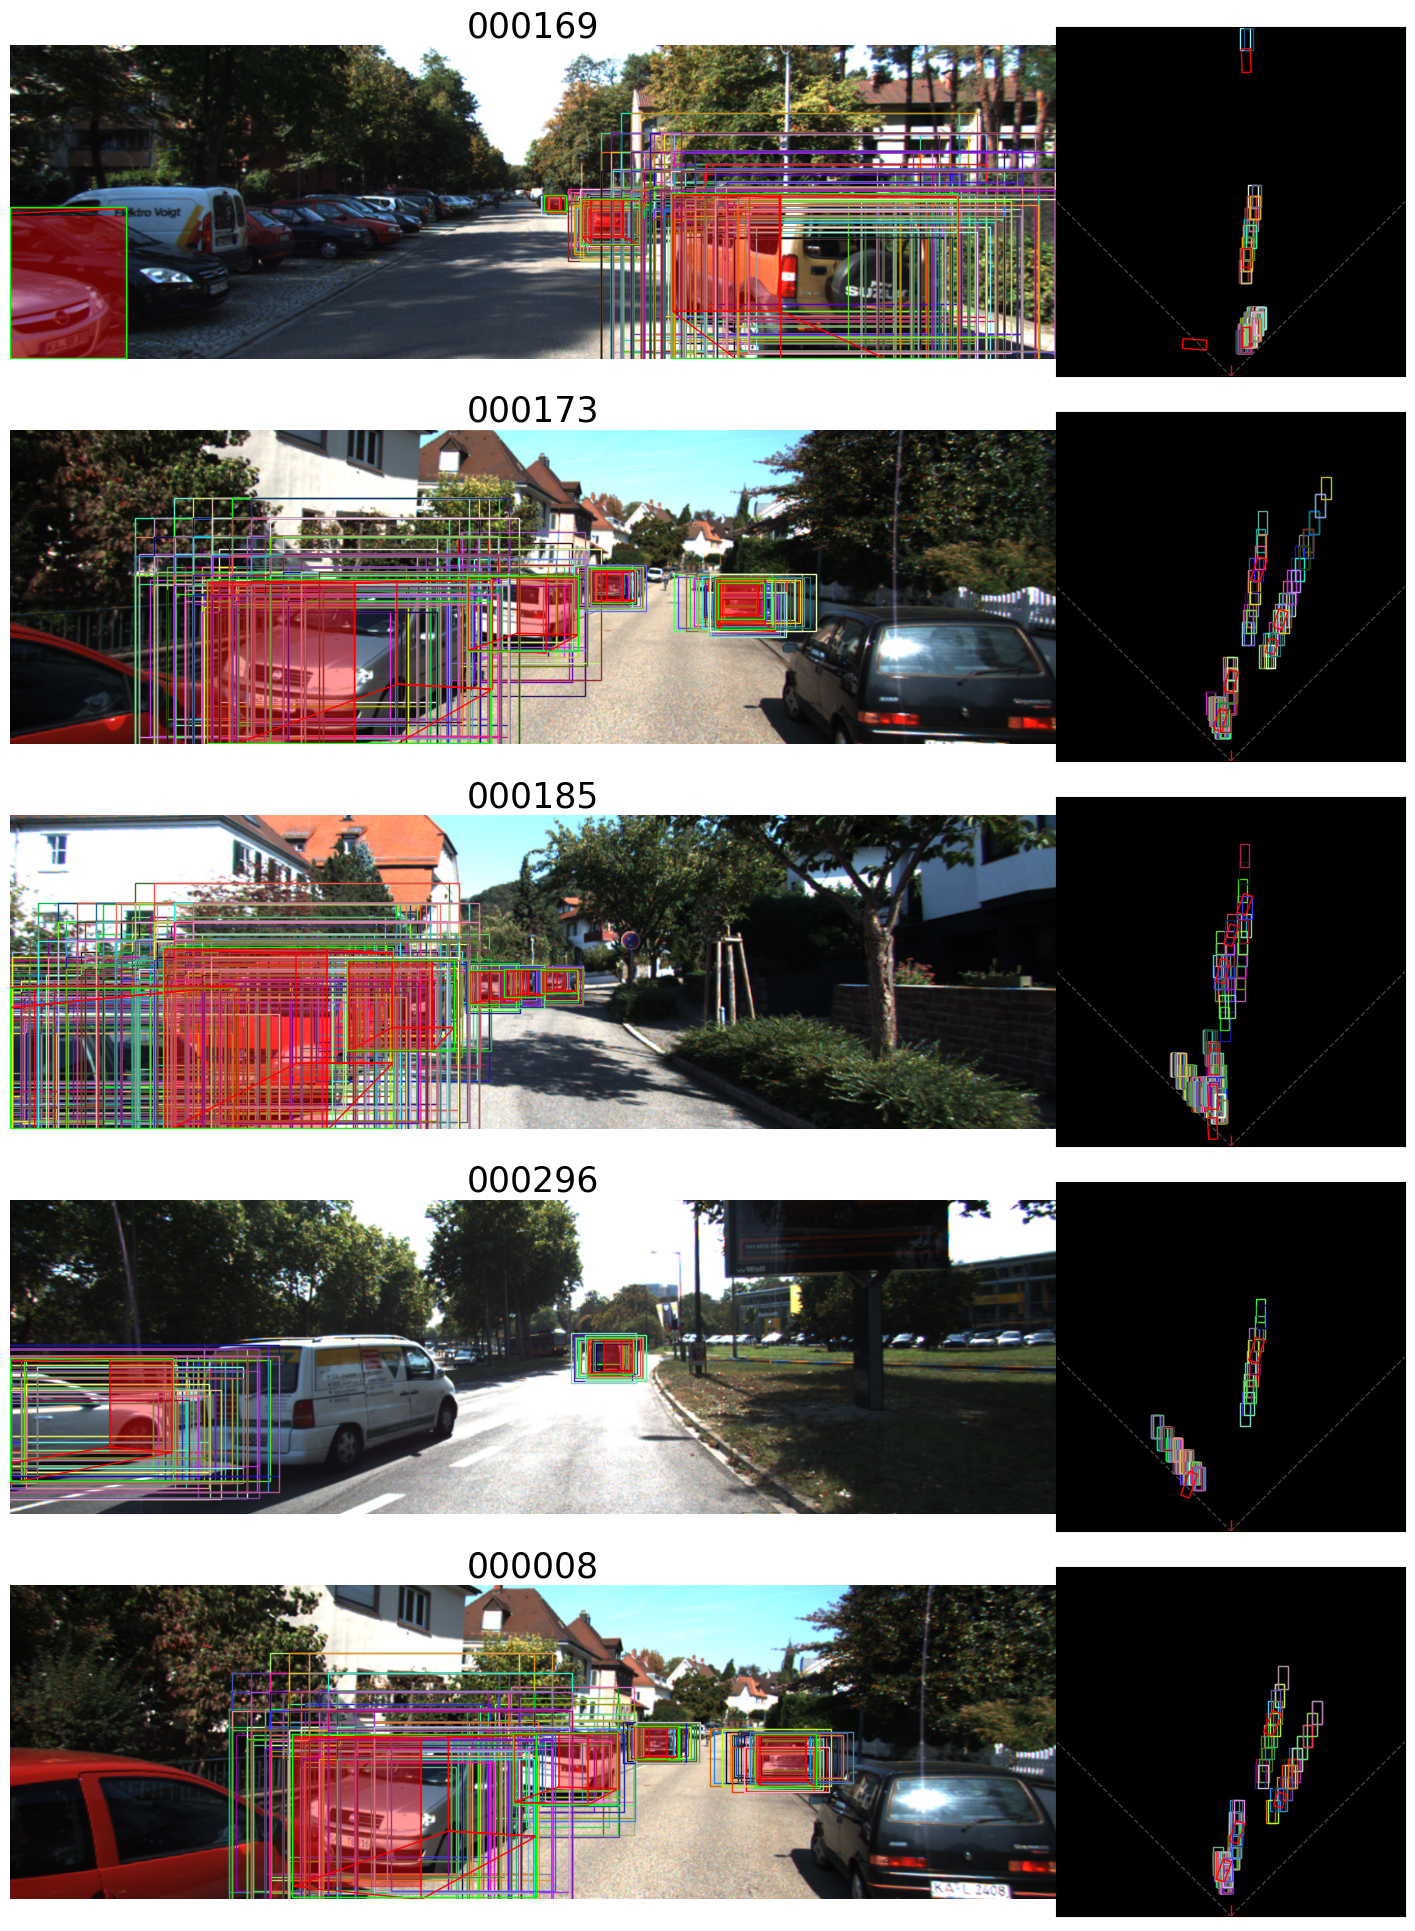

In [2]:
axs = init_img_plt(imgs_tf, SHOW_IMAGE)

assign_result = [[] for _ in range(len(labels_all))]

for idx_img in label_dict:
    # # TODO 
    # if idx_img != '000169': continue

    labels = [ labels_all[i] for i in label_dict[idx_img] ]
    if ANCHOR_ASSIGNMENT_METHOD == 'maxIoU':
        # Get labels_tensor for maxIoU
        labels_tensor = []
        for label in labels:
            labels_tensor.append([label.xmin, label.ymin, label.xmax, label.ymax])
        labels_tensor = torch.FloatTensor(labels_tensor)
        
        # Calculate maxIoU
        pos_inds, neg_inds, anchor_assignment = maxIoU(anchors_tensor, labels_tensor)

    elif ANCHOR_ASSIGNMENT_METHOD == '3Ddistance':
        ##################################################
        ### Anchor assignment via Norm_1 of (x3d, z3d) ###
        ##################################################
        # TODO maybe align with bev_ank_head.py
        # this won't work for now 
        raise NotImplementedError
        for idx_lable, label in enumerate(labels):
            norm_1 = abs(anchors_tensor[:, 12] - label.x3d) + abs(anchors_tensor[:, 14] - label.z3d)
            norm_1[ torch.abs(torch.cos(anchors_tensor[:, 15] - label.rot_y)) < pi/4 ] = float('inf')
            values, indexes = torch.topk(norm_1, 4, largest=False)
            pos_inds = indexes

    elif ANCHOR_ASSIGNMENT_METHOD == 'L1distance':
        ##################################################
        ### Anchor assignment via distance of (cx cy) ####
        ##################################################
        # TODO maybe align with bev_ank_head.py
        # this won't work for now 
        raise NotImplementedError
        for idx_lable, label in enumerate(labels):
            dist = abs(anchors_tensor[:, 5] - label.cx) + abs(anchors_tensor[:, 6] - label.cy)
            dist[ torch.abs(torch.cos(anchors_tensor[:, 15] - label.rot_y)) < pi/4 ] = float('inf')
            dist[ torch.abs(anchors_tensor[:, 7] - label.cz) > 2 ] = float('inf')
            pos_inds = torch.nonzero(dist < 16*1.414, as_tuple=False).squeeze()

    n_pos = pos_inds.shape[0]
    # n_neg = neg_inds.shape[0]
    if idx_img == '000008':
        print(f"n_pos = {n_pos}")
        print(f"pos_inds = {pos_inds}")

    n_gt = len(labels)
    # 
    unique, counts = torch.unique(anchor_assignment, return_counts=True)
    anchor_assign = dict(zip(unique.cpu().numpy(), counts.cpu().numpy())) # {0.0: 9308, 1.0: 24}
    
    for i in range(n_gt):
        if i in anchor_assign:
            # TODO don't know why 
            assign_list = (anchor_assignment == i).nonzero(as_tuple=True)[0].numpy().tolist()
            assign_result[ label_dict[idx_img][i] ] = assign_list
            # print(f"assign_list in assignemnt = {assign_list}")

    if idx_img in SHOW_IMAGE:
        idx_show = SHOW_IMAGE.index(idx_img)
        
        # Draw Positive anchors
        for i in range(n_pos):
            color = (random.random(), random.random(), random.random())
            # draw_corner_2D(axs[idx_show][0], anchors[pos_inds[i]].corner_2D, color = color, is_draw_front = False)
            draw_2Dbox(axs[idx_show][0], (anchors[pos_inds[i]].xmin, anchors[pos_inds[i]].ymin, anchors[pos_inds[i]].xmax, anchors[pos_inds[i]].ymax), color = color)
            draw_birdeyes(axs[idx_show][1], anchors[pos_inds[i]], color = color)

        # Draw ground true 3d bbox
        for label in labels:
            draw_corner_2D(axs[idx_show][0], label.corner_2D,  color = (1,0,0))
            draw_2Dbox(axs[idx_show][0], (label.xmin, label.ymin, label.xmax, label.ymax), color = (0,1,0))
            draw_birdeyes(axs[idx_show][1], label, color = (1,0,0))

# Get number of covered groundTrue
n_cover_gt = 0
for assign_list in assign_result:
    if len(assign_list) > 0:
        n_cover_gt += 1

# Get number of assignment
n_assign = 0
for assign_list in assign_result:
    n_assign += len(assign_list)

# Get average L1 distance
avg_cx_dist = 0
avg_cy_dist = 0
avg_x3d_dist = 0
avg_y3d_dist = 0
avg_z3d_dist = 0
for idx_label, assign_list in enumerate(assign_result):
    for idx_anchor in assign_list:
        avg_cx_dist += abs(anchors[idx_anchor].cx - labels_all[idx_label].cx) / n_assign
        avg_cy_dist += abs(anchors[idx_anchor].cy - labels_all[idx_label].cy) / n_assign
        avg_x3d_dist += abs(anchors[idx_anchor].x3d - labels_all[idx_label].x3d) / n_assign
        avg_y3d_dist += abs(anchors[idx_anchor].y3d - labels_all[idx_label].y3d) / n_assign
        avg_z3d_dist += abs(anchors[idx_anchor].z3d - labels_all[idx_label].z3d) / n_assign

print(f"Total number of Assignment = {n_assign}")
print(f"Total GroundTrue = {len(labels_all)}")
print(f"Total covered groundtrue = {n_cover_gt}")
print(f"Total missed groundtrue = {len(labels_all) - n_cover_gt}")
print(f"Average anchors for every groundtrue = {n_assign / len(labels_all)}")
print(f"Average cx distance = {avg_cx_dist}")
print(f"Average cy distance = {avg_cy_dist}")
print(f"Average x3d distance = {avg_x3d_dist}")
print(f"Average y3d distance = {avg_y3d_dist}")
print(f"Average z3d distance = {avg_z3d_dist}")
print(f"Cover rate = {100*n_cover_gt / len(labels_all)}%")


# Draw specified anchor assigment result for dubugging

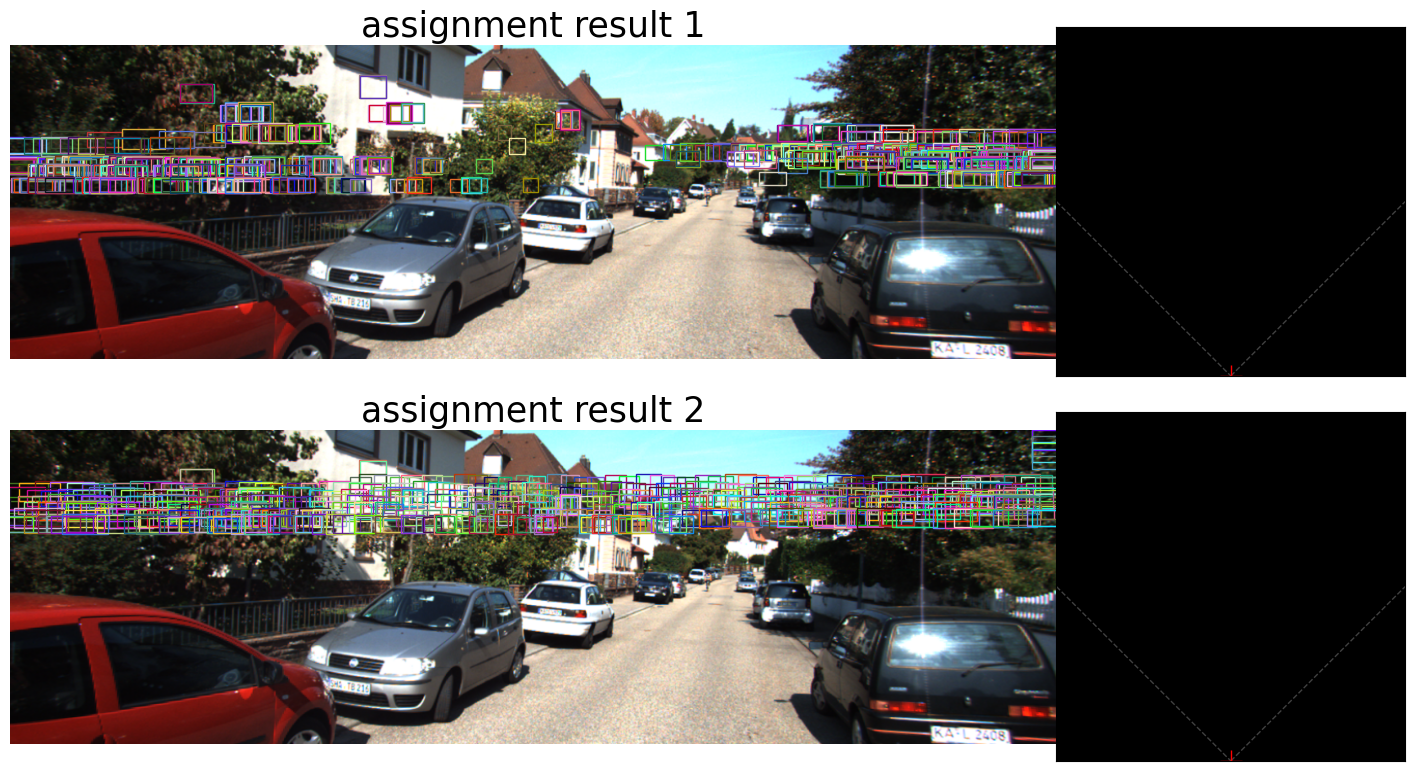

In [3]:
assignment_result_1 = torch.tensor([ 6090,  6091,  6890,  6891,  9806,  9807,  9808,  9809,  9810,  9811,
         9812,  9820,  9821,  9822,  9823,  9824,  9825,  9939,  9940,  9953,
         9954,  9955,  9956,  9957,  9958,  9967,  9968, 11066, 11067, 11068,
        11069, 11070, 11071, 12672, 12680, 12681, 12682, 12683, 12688, 12689,
        12690, 12691, 12692, 12697, 12704, 12705, 12712, 12713, 12714, 12715,
        12720, 12721, 12722, 12723, 12724, 12729, 12730, 12745, 12746, 12747,
        12753, 12754, 12755, 12756, 12935, 12967, 13196, 13197, 13228, 13229,
        13230, 13231, 13239, 13261, 13262, 13263, 13271, 13293, 13294, 13295,
        13496, 13528, 13560, 13592, 13624, 14216, 14224, 14240, 14248, 14256,
        14272, 14280, 14288, 14296, 14304, 14312, 14320, 14328, 14336, 14344,
        14352, 14360, 14368, 14376, 14384, 14392, 14400, 14408, 14416, 14432,
        14440, 14448, 14464, 14472, 14480, 14496, 14504, 14512, 14536, 14544,
        14864, 15952, 15968, 15976, 15984, 16000, 16008, 16016, 16024, 16032,
        16033, 16040, 16041, 16048, 16049, 16056, 16057, 16064, 16065, 16072,
        16073, 16080, 16081, 16088, 16089, 16096, 16097, 16104, 16105, 16112,
        16113, 16120, 16121, 16128, 16129, 16136, 16137, 16144, 16145, 16152,
        16153, 16160, 16161, 16168, 16169, 16176, 16177, 16184, 16185, 16192,
        16193, 16200, 16201, 16208, 16209, 16216, 16217, 16224, 16232, 16240,
        16241, 16248, 16249, 16264, 16272, 16940, 16941, 16989, 16990, 16996,
        16997, 17004, 17044, 17045, 17046, 17051, 17052, 17053, 17059, 17060,
        17100, 17101, 17102, 17107, 17108, 17109, 17114, 17115, 17116, 17123,
        17156, 17157, 17158, 17163, 17164, 17165, 17170, 17171, 17172, 17178,
        17179, 17212, 17213, 17214, 17219, 17220, 17221, 17226, 17227, 17228,
        17233, 17234, 17235, 17267, 17268, 17269, 17270, 17274, 17275, 17276,
        17277, 17281, 17282, 17283, 17284, 17289, 17290, 17291, 17297, 17323,
        17324, 17325, 17326, 17330, 17331, 17332, 17333, 17337, 17338, 17339,
        17340, 17345, 17346, 17347, 17352, 17353, 17379, 17380, 17381, 17382,
        17386, 17387, 17388, 17389, 17393, 17394, 17395, 17396, 17400, 17401,
        17402, 17403, 17408, 17435, 17436, 17437, 17438, 17442, 17443, 17444,
        17445, 17449, 17450, 17451, 17452, 17456, 17457, 17458, 17459, 17464,
        17491, 17492, 17493, 17494, 17498, 17499, 17500, 17501, 17505, 17506,
        17507, 17508, 17512, 17513, 17514, 17515, 17547, 17548, 17549, 17550,
        17554, 17555, 17556, 17557, 17561, 17562, 17563, 17564, 17568, 17569,
        17570, 17603, 17604, 17605, 17606, 17610, 17611, 17612, 17613, 17617,
        17618, 17619, 17620, 17659, 17660, 17661, 17666, 17667, 17668, 17669,
        17674, 17716, 17997, 18052, 18053, 18054, 18060, 18061, 18108, 18109,
        18110, 18115, 18116, 18117, 18123, 18124, 18163, 18164, 18165, 18166,
        18170, 18171, 18172, 18173, 18178, 18179, 18180, 18219, 18220, 18221,
        18222, 18226, 18227, 18228, 18229, 18233, 18234, 18235, 18236, 18241,
        18275, 18276, 18277, 18278, 18282, 18283, 18284, 18285, 18289, 18290,
        18291, 18292, 18297, 18331, 18332, 18333, 18334, 18338, 18339, 18340,
        18341, 18345, 18346, 18347, 18352, 18353, 18387, 18388, 18389, 18394,
        18395, 18396, 18397, 18401, 18402, 18403, 18409, 18443, 18444, 18445,
        18450, 18451, 18452, 18453, 18458, 18459, 18500, 18501, 19900, 19956,
        19957, 19963, 19964, 19965, 19970, 19971, 20012, 20013, 20014, 20019,
        20020, 20021, 20026, 20027, 20028, 20068, 20069, 20070, 20075, 20076,
        20077, 20082, 20083, 20084, 20090, 20091, 20124, 20125, 20126, 20131,
        20132, 20133, 20138, 20139, 20140, 20146, 20147, 20180, 20181, 20182,
        20187, 20188, 20189, 20194, 20195, 20196, 20202, 20203, 20210, 20236,
        20237, 20238, 20243, 20244, 20245, 20250, 20251, 20252, 20258, 20259,
        20266, 20292, 20293, 20294, 20299, 20300, 20301, 20306, 20307, 20308,
        20314, 20315, 20322, 20348, 20349, 20350, 20355, 20356, 20357, 20363,
        20364, 20370, 20371, 20378, 20404, 20405, 20406, 20411, 20412, 20413,
        20419, 20420, 20426, 20427, 20460, 20461, 20462, 20468, 20469, 20475,
        20476, 20483, 20517, 20518, 20524, 20525, 20531, 20532, 20573, 20580,
        20581, 20588, 20637], device='cuda:1')

assignment_result_2 = torch.tensor([ 5900,  5901,  6700,  6701,  9407,  9408,  9409,  9421,  9422,  9423,
         9424,  9425,  9426,  9435,  9540,  9541,  9542,  9543,  9544,  9545,
         9546,  9554,  9555,  9556,  9557,  9558,  9559,  9560, 10520, 10521,
        10534, 10535, 10536, 10537, 10538, 10539, 11704, 11736, 11768, 11800,
        12013, 12014, 12015, 12023, 12044, 12045, 12046, 12047, 12055, 12076,
        12077, 12078, 12079, 12327, 12359, 12530, 12531, 12544, 12552, 12553,
        12554, 12555, 12560, 12561, 12562, 12563, 12564, 12569, 12570, 12576,
        12577, 12584, 12585, 12586, 12587, 12592, 12593, 12594, 12595, 12596,
        12601, 12602, 12617, 12618, 12625, 12626, 12627, 12628, 14120, 14128,
        14144, 14152, 14160, 14176, 14184, 14185, 14192, 14193, 14200, 14201,
        14208, 14209, 14216, 14217, 14224, 14225, 14232, 14233, 14240, 14241,
        14248, 14249, 14256, 14257, 14264, 14265, 14272, 14273, 14280, 14281,
        14288, 14289, 14296, 14297, 14304, 14305, 14312, 14313, 14320, 14321,
        14328, 14329, 14336, 14337, 14344, 14345, 14352, 14353, 14360, 14361,
        14368, 14376, 14384, 14385, 14392, 14393, 14400, 14408, 14416, 14424,
        14440, 14448, 15504, 15528, 15536, 15560, 15568, 15848, 15856, 15872,
        15880, 15888, 15904, 15912, 15920, 15936, 15944, 15952, 15968, 15976,
        15984, 15992, 16000, 16008, 16016, 16024, 16032, 16040, 16048, 16056,
        16064, 16072, 16080, 16088, 16096, 16104, 16112, 16120, 16128, 16136,
        16144, 16152, 16160, 16168, 16176, 16208, 16828, 16829, 16877, 16878,
        16884, 16885, 16892, 16932, 16933, 16934, 16940, 16941, 16947, 16948,
        16955, 16988, 16989, 16990, 16995, 16996, 16997, 17003, 17004, 17010,
        17011, 17044, 17045, 17046, 17051, 17052, 17053, 17058, 17059, 17060,
        17066, 17067, 17074, 17100, 17101, 17102, 17107, 17108, 17109, 17114,
        17115, 17116, 17122, 17123, 17130, 17156, 17157, 17158, 17163, 17164,
        17165, 17170, 17171, 17172, 17178, 17179, 17186, 17212, 17213, 17214,
        17219, 17220, 17221, 17226, 17227, 17228, 17234, 17235, 17242, 17268,
        17269, 17270, 17275, 17276, 17277, 17282, 17283, 17284, 17290, 17291,
        17324, 17325, 17326, 17331, 17332, 17333, 17338, 17339, 17340, 17346,
        17347, 17380, 17381, 17382, 17387, 17388, 17389, 17394, 17395, 17396,
        17436, 17437, 17443, 17444, 17445, 17450, 17451, 17492, 17500, 18891,
        18892, 18893, 18898, 18899, 18947, 18948, 18949, 18954, 18955, 18956,
        18957, 18961, 18962, 18963, 19003, 19004, 19005, 19006, 19010, 19011,
        19012, 19013, 19017, 19018, 19019, 19024, 19025, 19059, 19060, 19061,
        19062, 19066, 19067, 19068, 19069, 19073, 19074, 19075, 19076, 19080,
        19081, 19115, 19116, 19117, 19118, 19122, 19123, 19124, 19125, 19129,
        19130, 19131, 19132, 19137, 19171, 19172, 19173, 19174, 19178, 19179,
        19180, 19181, 19185, 19186, 19187, 19188, 19193, 19194, 19227, 19228,
        19229, 19230, 19234, 19235, 19236, 19237, 19242, 19243, 19244, 19250,
        19284, 19285, 19286, 19291, 19292, 19293, 19299, 19300, 19340, 19341,
        19342, 19348, 19349, 19397, 19676, 19731, 19732, 19733, 19738, 19739,
        19740, 19746, 19787, 19788, 19789, 19794, 19795, 19796, 19797, 19801,
        19802, 19803, 19843, 19844, 19845, 19846, 19850, 19851, 19852, 19853,
        19857, 19858, 19859, 19860, 19864, 19865, 19899, 19900, 19901, 19902,
        19906, 19907, 19908, 19909, 19913, 19914, 19915, 19916, 19920, 19921,
        19922, 19923, 19955, 19956, 19957, 19958, 19962, 19963, 19964, 19965,
        19969, 19970, 19971, 19972, 19977, 19978, 19979, 19984, 20011, 20012,
        20013, 20014, 20018, 20019, 20020, 20021, 20025, 20026, 20027, 20028,
        20033, 20034, 20035, 20040, 20041, 20067, 20068, 20069, 20070, 20074,
        20075, 20076, 20077, 20081, 20082, 20083, 20084, 20089, 20090, 20091,
        20096, 20097, 20123, 20124, 20125, 20126, 20130, 20131, 20132, 20133,
        20138, 20139, 20140, 20145, 20146, 20147, 20153, 20180, 20181, 20182,
        20187, 20188, 20189, 20194, 20195, 20196, 20201, 20202, 20203, 20236,
        20237, 20238, 20243, 20244, 20245, 20250, 20251, 20252, 20258, 20259,
        20292, 20293, 20294, 20299, 20300, 20301, 20306, 20307, 20308, 20315,
        20348, 20349, 20350, 20355, 20356, 20357, 20363, 20364, 20405, 20406,
        20412, 20413, 20420, 20461, 20468, 20469], device='cuda:1')

assignment_result_2 = torch.tensor([  957,  1917,  2877,  3837,  4797,  6090,  6091,  6890,  6891,  8003,
         8010,  8023,  8038,  8047,  8051,  8066,  8079,  8094,  8107,  8122,
         8135,  8150,  8163,  8178,  8191,  8206,  8219,  8234,  8247,  8262,
         8275,  8290,  8303,  8318,  8331,  8346,  8359,  8374,  8387,  8402,
         8415,  8430,  8443,  8458,  8471,  8486,  8499,  8514,  8527,  8542,
         8555,  8570,  8583,  8598,  8611,  8626,  8639,  8654,  8667,  8682,
         8695,  8710,  8723,  8738,  8751,  8766,  8779,  8794,  8807,  8822,
         8835,  8850,  8863,  8878,  8891,  8906,  8919,  8934,  8947,  8962,
         8975,  8990,  9003,  9018,  9031,  9046,  9059,  9074,  9087,  9093,
         9102,  9105,  9115,  9123,  9130,  9143,  9157,  9158,  9164,  9171,
         9186,  9199,  9214,  9227,  9242,  9255,  9270,  9283,  9298,  9311,
         9326,  9339,  9354,  9367,  9382,  9395,  9410,  9423,  9438,  9451,
         9466,  9479,  9494,  9507,  9522,  9535,  9550,  9563,  9578,  9591,
         9606,  9619,  9634,  9647,  9662,  9675,  9690,  9703,  9718,  9731,
         9746,  9759,  9774,  9787,  9802,  9806,  9807,  9808,  9809,  9810,
         9811,  9812,  9815,  9820,  9821,  9822,  9823,  9824,  9825,  9830,
         9843,  9858,  9871,  9886,  9899,  9914,  9927,  9939,  9940,  9942,
         9953,  9954,  9956,  9957,  9958,  9967,  9968,  9970,  9983,  9998,
        10011, 10026, 10039, 10054, 10067, 10082, 10095, 10110, 10123, 10138,
        10151, 10166, 10179, 10194, 10207, 10213, 10222, 10225, 10235, 10247,
        10250, 10256, 10257, 10263, 10278, 10284, 10291, 10306, 10319, 10334,
        10347, 10362, 10375, 10390, 10403, 10418, 10431, 10446, 10459, 10474,
        10487, 10502, 10515, 10530, 10543, 10558, 10571, 10586, 10599, 10614,
        10627, 10642, 10655, 10670, 10683, 10698, 10711, 10726, 10739, 10754,
        10767, 10782, 10795, 10810, 10823, 10838, 10851, 10866, 10879, 10894,
        10907, 10922, 10935, 10950, 10963, 10978, 10991, 11006, 11019, 11034,
        11047, 11062, 11066, 11067, 11068, 11069, 11070, 11071, 11075, 11090,
        11103, 11118, 11131, 11146, 11159, 11174, 11187, 11202, 11215, 11230,
        11243, 11258, 11271, 11286, 11299, 11314, 11327, 11333, 11342, 11345,
        11355, 11361, 11365, 11369, 11374, 11384, 11408, 11412, 11414, 11424,
        11426, 11436, 11440, 11445, 11449, 11454, 11458, 11461, 11466, 11479,
        11481, 11482, 11483, 11489, 11552, 11564, 11571, 11581, 11586, 11589,
        11617, 11621, 11670, 11680, 11692, 11699, 11714, 11717, 11736, 11738,
        11745, 11753, 11808, 11820, 11827, 11842, 11845, 11864, 11866, 11873,
        11896, 11936, 11948, 11952, 11955, 11970, 11973, 11992, 12001, 12064,
        12076, 12083, 12098, 12101, 12104, 12120, 12129, 12192, 12204, 12211,
        12226, 12229, 12248, 12257, 12320, 12332, 12339, 12354, 12357, 12376,
        12385, 12448, 12460, 12467, 12482, 12485, 12504, 12513, 12548, 12576,
        12588, 12595, 12610, 12613, 12621, 12632, 12641, 12669, 12672, 12680,
        12681, 12682, 12683, 12688, 12689, 12690, 12691, 12692, 12697, 12705,
        12712, 12713, 12714, 12715, 12716, 12721, 12722, 12724, 12729, 12730,
        12738, 12741, 12745, 12746, 12747, 12749, 12753, 12754, 12755, 12756,
        12760, 12769, 12777, 12832, 12844, 12851, 12866, 12869, 12888, 12897,
        12925, 12935, 12960, 12967, 12972, 12979, 12994, 12997, 13016, 13025,
        13053, 13088, 13100, 13107, 13122, 13125, 13144, 13153, 13181, 13188,
        13196, 13197, 13216, 13229, 13230, 13231, 13235, 13239, 13250, 13253,
        13261, 13262, 13263, 13271, 13272, 13281, 13293, 13295, 13304, 13309,
        13344, 13356, 13363, 13378, 13381, 13400, 13409, 13432, 13437, 13444,
        13455, 13472, 13484, 13491, 13496, 13506, 13509, 13537, 13561, 13565,
        13572, 13583, 13592, 13600, 13612, 13619, 13624, 13634, 13637, 13640,
        13656, 13665, 13668, 13688, 13689, 13693, 13700, 13711, 13713, 13728,
        13740, 13747, 13762, 13765, 13784, 13793, 13807, 13810, 13821, 13822,
        13828, 13836, 13839, 13856, 13863, 13868, 13875, 13890, 13902, 13912,
        13925, 13926, 13929, 13936, 13969, 13972, 13979, 13981, 13984, 13986,
        13996, 14000, 14003, 14005, 14009, 14015, 14018, 14021, 14039, 14042,
        14043, 14049, 14054, 14057, 14071, 14112, 14124, 14128, 14131, 14133,
        14141, 14146, 14149, 14168, 14170, 14177, 14184, 14185, 14207, 14216,
        14224, 14248, 14252, 14256, 14259, 14261, 14272, 14274, 14275, 14277,
        14288, 14298, 14304, 14305, 14312, 14313, 14320, 14336, 14344, 14352,
        14376, 14380, 14384, 14387, 14392, 14400, 14402, 14403, 14405, 14408,
        14409, 14416, 14424, 14432, 14433, 14440, 14448, 14456, 14464, 14472,
        14480, 14504, 14508, 14512, 14515, 14517, 14530, 14531, 14533, 14544,
        14561, 14569, 14584, 14608, 14612, 14624, 14636, 14643, 14645, 14658,
        14659, 14661, 14664, 14680, 14689, 14752, 14764, 14771, 14786, 14787,
        14789, 14808, 14817, 14864, 14880, 14892, 14899, 14914, 14915, 14917,
        14920, 14945, 15008, 15020, 15027, 15042, 15045, 15048, 15064, 15073,
        15136, 15148, 15155, 15170, 15173, 15176, 15192, 15201, 15264, 15276,
        15283, 15298, 15301, 15304, 15320, 15329, 15392, 15404, 15411, 15426,
        15429, 15448, 15457, 15520, 15532, 15539, 15554, 15557, 15576, 15585,
        15608, 15613, 15648, 15660, 15667, 15682, 15685, 15704, 15713, 15736,
        15741, 15776, 15788, 15795, 15810, 15813, 15816, 15832, 15841, 15864,
        15869, 15904, 15916, 15923, 15938, 15941, 15944, 15952, 15960, 15968,
        15969, 15976, 15984, 15992, 15997, 16008, 16016, 16033, 16040, 16041,
        16044, 16048, 16051, 16056, 16057, 16064, 16065, 16066, 16069, 16073,
        16079, 16080, 16081, 16089, 16096, 16104, 16105, 16112, 16113, 16114,
        16125, 16128, 16129, 16136, 16137, 16144, 16153, 16161, 16168, 16169,
        16172, 16179, 16183, 16184, 16185, 16192, 16193, 16194, 16197, 16201,
        16208, 16209, 16217, 16224, 16225, 16232, 16240, 16241, 16242, 16249,
        16253, 16260, 16264, 16270, 16272, 16273, 16280, 16288, 16300, 16303,
        16307, 16312, 16322, 16325, 16328, 16344, 16353, 16362, 16370, 16371,
        16375, 16381, 16382, 16385, 16388, 16393, 16395, 16396, 16399, 16415,
        16416, 16428, 16435, 16450, 16453, 16456, 16472, 16480, 16481, 16484,
        16492, 16494, 16498, 16501, 16505, 16510, 16525, 16527, 16534, 16535,
        16538, 16546, 16548, 16549, 16554, 16556, 16567, 16568, 16569, 16572,
        16574, 16575, 16577, 16581, 16583, 16587, 16590, 16593, 16595, 16596,
        16598, 16599, 16601, 16607, 16613, 16623, 16624, 16633, 16645, 16646,
        16651, 16655, 16657, 16664, 16666, 16667, 16668, 16677, 16683, 16686,
        16691, 16693, 16694, 16703, 16707, 16713, 16715, 16716, 16732, 16733,
        16734, 16741, 16745, 16748, 16751, 16756, 16758, 16759, 16767, 16772,
        16773, 16777, 16780, 16794, 16796, 16797, 16799, 16817, 16820, 16822,
        16827, 16829, 16830, 16834, 16836, 16839, 16840, 16842, 16844, 16845,
        16846, 16857, 16866, 16867, 16875, 16883, 16884, 16888, 16890, 16892,
        16897, 16901, 16906, 16909, 16913, 16916, 16928, 16929, 16931, 16932,
        16942, 16949, 16953, 16965, 16967, 16972, 16973, 16975, 16982, 16995,
        17001, 17002, 17004, 17016, 17017, 17018, 17019, 17020, 17022, 17025,
        17027, 17032, 17035, 17036, 17041, 17043, 17047, 17049, 17050, 17051,
        17052, 17053, 17055, 17059, 17060, 17061, 17065, 17066, 17067, 17069,
        17072, 17076, 17081, 17090, 17094, 17099, 17105, 17109, 17111, 17112,
        17120, 17125, 17131, 17139, 17143, 17151, 17155, 17161, 17165, 17166,
        17167, 17175, 17179, 17180, 17181, 17182, 17189, 17193, 17195, 17196,
        17197, 17204, 17213, 17215, 17219, 17225, 17233, 17234, 17235, 17242,
        17245, 17247, 17248, 17249, 17250, 17263, 17269, 17274, 17276, 17281,
        17288, 17289, 17293, 17294, 17297, 17298, 17302, 17309, 17313, 17324,
        17325, 17336, 17339, 17346, 17347, 17353, 17354, 17357, 17360, 17361,
        17364, 17377, 17382, 17385, 17387, 17389, 17390, 17393, 17394, 17395,
        17396, 17397, 17400, 17401, 17403, 17406, 17408, 17421, 17423, 17430,
        17435, 17436, 17437, 17440, 17442, 17451, 17452, 17456, 17457, 17458,
        17459, 17465, 17468, 17470, 17473, 17475, 17480, 17481, 17484, 17489,
        17493, 17495, 17497, 17500, 17501, 17503, 17505, 17506, 17507, 17508,
        17509, 17510, 17512, 17513, 17517, 17520, 17529, 17549, 17550, 17557,
        17560, 17561, 17569, 17570, 17571, 17573, 17579, 17587, 17605, 17609,
        17613, 17614, 17615, 17620, 17623, 17626, 17628, 17629, 17630, 17637,
        17641, 17643, 17644, 17651, 17652, 17655, 17659, 17661, 17662, 17663,
        17666, 17675, 17690, 17695, 17697, 17711, 17718, 17722, 17723, 17730,
        17732, 17736, 17737, 17738, 17741, 17742, 17757, 17761, 17771, 17772,
        17777, 17779, 17784, 17786, 17788, 17793, 17802, 17805, 17809, 17828,
        17833, 17836, 17837, 17838, 17845, 17854, 17863, 17868, 17869, 17871,
        17884, 17888, 17890, 17892, 17898, 17913, 17916, 17918, 17921, 17927,
        17928, 17929, 17930, 17937, 17940, 17942, 17943, 17945, 17946, 17951,
        17957, 17963, 17965, 17968, 17977, 17983, 17995, 18003, 18004, 18008,
        18010, 18011, 18012, 18016, 18021, 18024, 18027, 18035, 18042, 18047,
        18051, 18053, 18057, 18059, 18061, 18062, 18067, 18068, 18071, 18076,
        18077, 18078, 18084, 18085, 18089, 18091, 18092, 18100, 18103, 18108,
        18109, 18111, 18122, 18138, 18141, 18143, 18144, 18165, 18173, 18174,
        18179, 18184, 18186, 18189, 18190, 18194, 18205, 18209, 18221, 18222,
        18225, 18226, 18228, 18232, 18235, 18250, 18253, 18257, 18271, 18272,
        18273, 18277, 18278, 18281, 18282, 18283, 18286, 18289, 18291, 18293,
        18311, 18312, 18316, 18317, 18319, 18331, 18334, 18335, 18336, 18341,
        18347, 18352, 18353, 18360, 18361, 18364, 18366, 18369, 18371, 18376,
        18377, 18378, 18380, 18385, 18387, 18390, 18391, 18393, 18395, 18396,
        18397, 18399, 18401, 18402, 18403, 18405, 18410, 18411, 18413, 18415,
        18416, 18425, 18448, 18451, 18453, 18456, 18460, 18464, 18466, 18469,
        18475, 18483, 18495, 18499, 18502, 18505, 18507, 18508, 18510, 18515,
        18519, 18524, 18525, 18526, 18533, 18537, 18539, 18540, 18548, 18551,
        18556, 18558, 18559, 18563, 18564, 18565, 18569, 18570, 18571, 18572,
        18586, 18589, 18591, 18612, 18614, 18616, 18619, 18622, 18626, 18628,
        18632, 18634, 18635, 18637, 18638, 18653, 18657, 18667, 18673, 18680,
        18682, 18684, 18689, 18698, 18701, 18705, 18708, 18719, 18721, 18724,
        18729, 18732, 18734, 18741, 18750, 18759, 18760, 18765, 18767, 18780,
        18783, 18784, 18788, 18794, 18809, 18812, 18814, 18817, 18824, 18825,
        18828, 18833, 18836, 18837, 18838, 18839, 18841, 18842, 18847, 18853,
        18858, 18859, 18861, 18873, 18891, 18900, 18904, 18907, 18908, 18912,
        18914, 18917, 18920, 18923, 18931, 18943, 18947, 18950, 18955, 18956,
        18958, 18963, 18967, 18972, 18973, 18974, 18980, 18981, 18985, 18987,
        18988, 18995, 18996, 18999, 19006, 19007, 19008, 19011, 19012, 19013,
        19018, 19019, 19034, 19037, 19039, 19053, 19060, 19062, 19067, 19074,
        19076, 19080, 19082, 19085, 19086, 19101, 19115, 19116, 19121, 19128,
        19130, 19132, 19137, 19146, 19149, 19153, 19167, 19172, 19177, 19180,
        19181, 19182, 19189, 19207, 19212, 19213, 19215, 19228, 19231, 19232,
        19235, 19236, 19241, 19242, 19244, 19260, 19262, 19265, 19272, 19273,
        19281, 19284, 19287, 19289, 19290, 19295, 19301, 19306, 19307, 19309,
        19327, 19333, 19339, 19348, 19352, 19355, 19356, 19360, 19365, 19368,
        19371, 19379, 19386, 19391, 19395, 19396, 19397, 19398, 19403, 19404,
        19406, 19415, 19420, 19421, 19422, 19424, 19428, 19429, 19433, 19435,
        19436, 19443, 19444, 19447, 19454, 19455, 19459, 19460, 19461, 19466,
        19467, 19482, 19485, 19501, 19502, 19508, 19510, 19512, 19515, 19518,
        19522, 19524, 19528, 19530, 19533, 19534, 19549, 19553, 19561, 19563,
        19569, 19576, 19578, 19580, 19585, 19592, 19594, 19597, 19601, 19615,
        19623, 19625, 19628, 19630, 19637, 19655, 19661, 19663, 19672, 19676,
        19679, 19680, 19683, 19684, 19685, 19690, 19705, 19708, 19710, 19713,
        19720, 19721, 19732, 19735, 19736, 19737, 19738, 19743, 19749, 19750,
        19755, 19757, 19775, 19776, 19781, 19783, 19787, 19796, 19800, 19803,
        19804, 19813, 19814, 19816, 19819, 19827, 19834, 19839, 19843, 19844,
        19846, 19849, 19851, 19852, 19854, 19863, 19868, 19869, 19870, 19874,
        19876, 19877, 19881, 19884, 19891, 19892, 19895, 19900, 19902, 19903,
        19907, 19909, 19914, 19915, 19916, 19930, 19933, 19935, 19949, 19955,
        19957, 19958, 19960, 19971, 19972, 19976, 19978, 19981, 19982, 19997,
        20001, 20011, 20013, 20014, 20017, 20019, 20020, 20024, 20027, 20033,
        20040, 20042, 20049, 20060, 20063, 20068, 20069, 20070, 20071, 20073,
        20078, 20083, 20084, 20085, 20092, 20097, 20103, 20108, 20109, 20111,
        20118, 20120, 20123, 20125, 20126, 20128, 20133, 20146, 20148, 20153,
        20156, 20158, 20161, 20168, 20169, 20170, 20181, 20183, 20186, 20187,
        20188, 20189, 20191, 20194, 20195, 20196, 20197, 20205, 20210, 20213,
        20223, 20224, 20229, 20231, 20233, 20235, 20236, 20238, 20243, 20248,
        20250, 20261, 20267, 20275, 20276, 20283, 20287, 20301, 20302, 20306,
        20307, 20308, 20311, 20314, 20315, 20316, 20324, 20325, 20326, 20329,
        20332, 20334, 20338, 20339, 20343, 20348, 20349, 20351, 20356, 20370,
        20381, 20382, 20408, 20413, 20418, 20419, 20427, 20429, 20430, 20445,
        20448, 20449, 20451, 20457, 20461, 20462, 20465, 20468, 20472, 20474,
        20475, 20481, 20488, 20490, 20493, 20500, 20507, 20508, 20511, 20515,
        20517, 20519, 20521, 20523, 20526, 20530, 20531, 20532, 20533, 20538,
        20539, 20540, 20557, 20568, 20569, 20572, 20576, 20577, 20579, 20581,
        20589, 20592, 20595, 20596, 20603, 20604, 20606, 20615, 20616, 20617,
        20624, 20631, 20634, 20639, 20645, 20651, 20653, 20656, 20659, 20671,
        20672, 20673, 20679, 20680, 20683, 20686, 20692, 20693, 20696, 20699,
        20700, 20703, 20705, 20706, 20709, 20714, 20716, 20724, 20731, 20737,
        20741, 20748, 20750, 20759, 20762, 20764, 20770, 20772, 20774, 20777,
        20780, 20782, 20784, 20786, 20787, 20790, 20791, 20796, 20798, 20799,
        20800, 20803, 20805, 20806, 20811, 20812, 20819, 20826, 20831, 20834,
        20852, 20853, 20856, 20859, 20862, 20865, 20866, 20868, 20871, 20872,
        20874, 20877, 20878, 20880, 20883, 20884, 20893, 20896, 20897, 20901,
        20905, 20917, 20924, 20926, 20936, 20938, 20953, 20954, 20956, 20958,
        20959], device='cuda:1')



axs = init_img_plt([imgs_tf[4], imgs_tf[4]], ["assignment result 1", "assignment result 2"])

# print(len(anchors)) # 20960
idx_show = 0
n_pos_1 = assignment_result_1.shape[0]
n_pos_2 = assignment_result_1.shape[0]

for i in range(n_pos_1):
    color = (random.random(), random.random(), random.random())
    # draw_corner_2D(axs[idx_show][0], anchors[pos_inds[i]].corner_2D, color = color, is_draw_front = False)
    draw_2Dbox(axs[0][0], (anchors[assignment_result_1[i]].xmin, 
                           anchors[assignment_result_1[i]].ymin, 
                           anchors[assignment_result_1[i]].xmax, 
                           anchors[assignment_result_1[i]].ymax), color = color)
    # draw_birdeyes(axs[idx_show][1], anchors[pos_inds[i]], color = color)

for i in range(n_pos_2):
    color = (random.random(), random.random(), random.random())
    # draw_corner_2D(axs[idx_show][0], anchors[pos_inds[i]].corner_2D, color = color, is_draw_front = False)
    draw_2Dbox(axs[1][0], (anchors[assignment_result_2[i]].xmin, 
                           anchors[assignment_result_2[i]].ymin, 
                           anchors[assignment_result_2[i]].xmax, 
                           anchors[assignment_result_2[i]].ymax), color = color)
    # draw_birdeyes(axs[idx_show][1], anchors[pos_inds[i]], color = color)


# Analyse anchor assignment on ZY plane

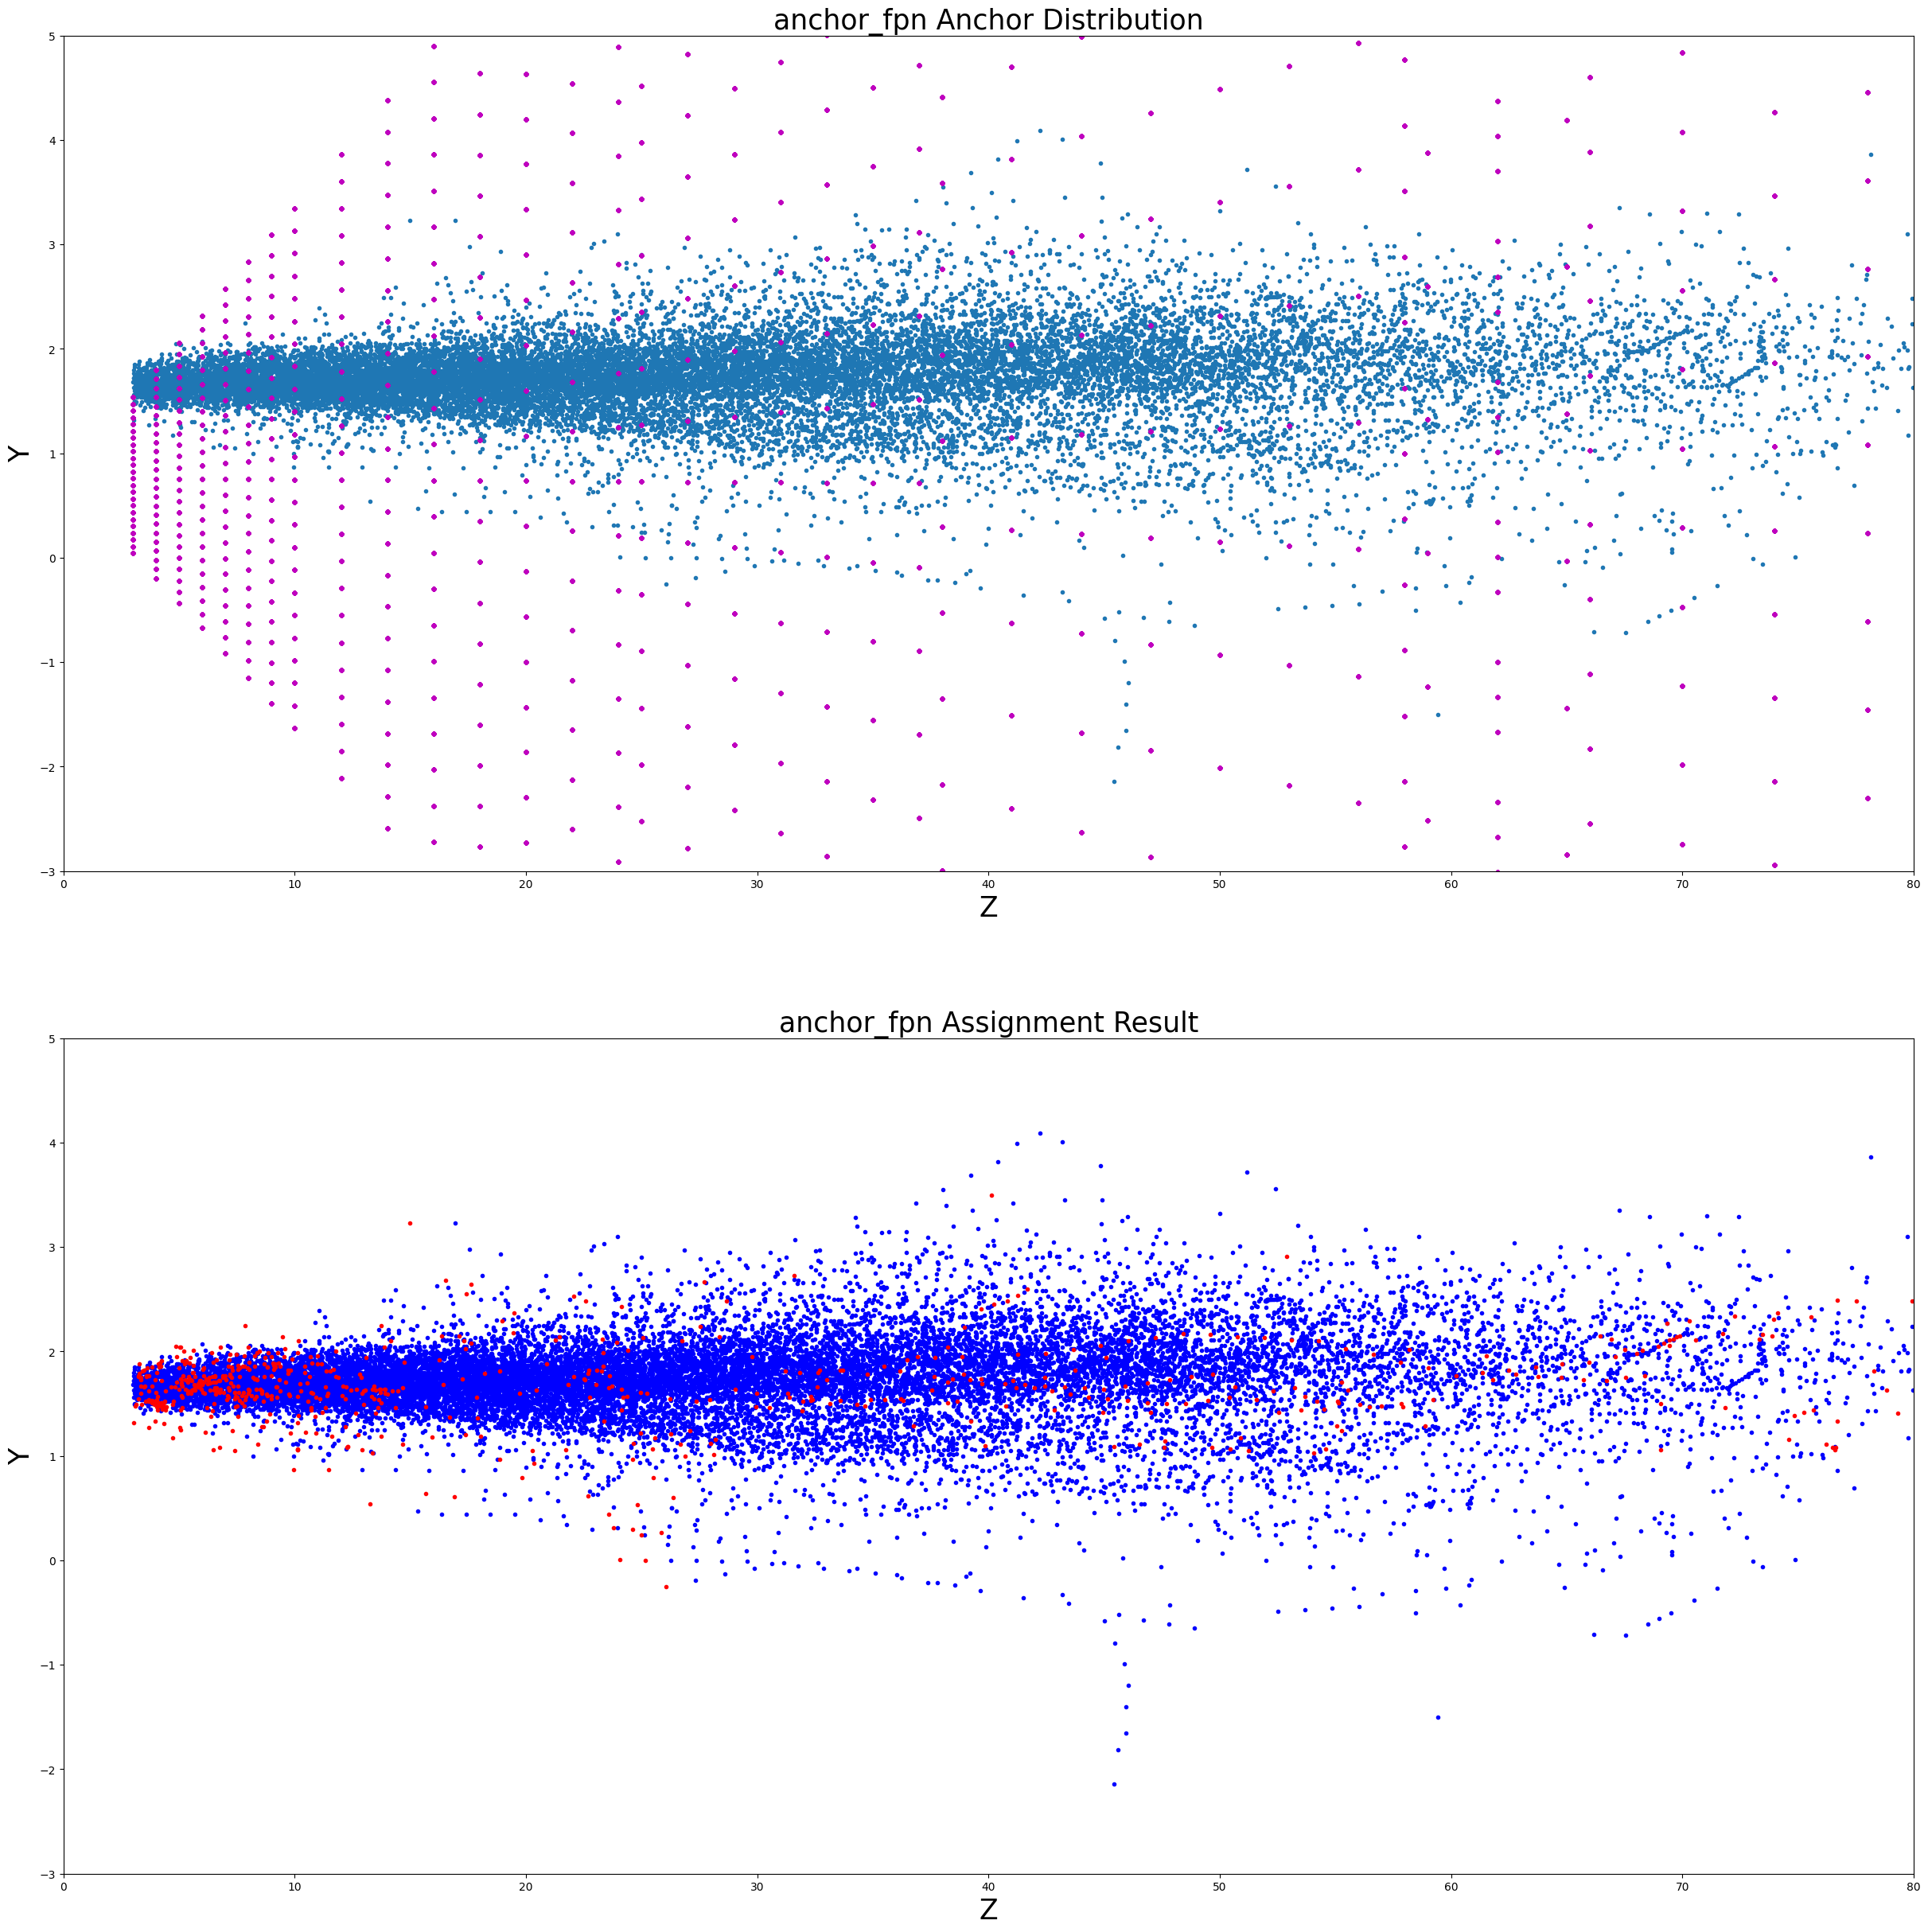

In [4]:
axs = init_zy_plt([f"{ANCHOR_GENERATION_METHOD} Anchor Distribution", f"{ANCHOR_GENERATION_METHOD} Assignment Result"])

# Draw Ground true
axs[0].plot([l.z3d for l in labels_all], [l.y3d for l in labels_all], '.') # Draw ground true

# Draw anchors
axs[0].plot([a.z3d for a in anchors], [a.y3d for a in anchors], '.m',) # Draw filtered GAC anchor

covered_gt_list = []
missed_gt_list = []
for i, assign_list in enumerate(assign_result):
    if len(assign_list) > 0: # Covered gt
        covered_gt_list.append(i)
    else:
        missed_gt_list.append(i)

# Draw Assignemnt result
axs[1].plot([labels_all[i].z3d for i in covered_gt_list], [labels_all[i].y3d for i in covered_gt_list], '.b',)
axs[1].plot([labels_all[i].z3d for i in missed_gt_list], [labels_all[i].y3d for i in missed_gt_list], '.r',)



# Anchor Assignment on XZ plane

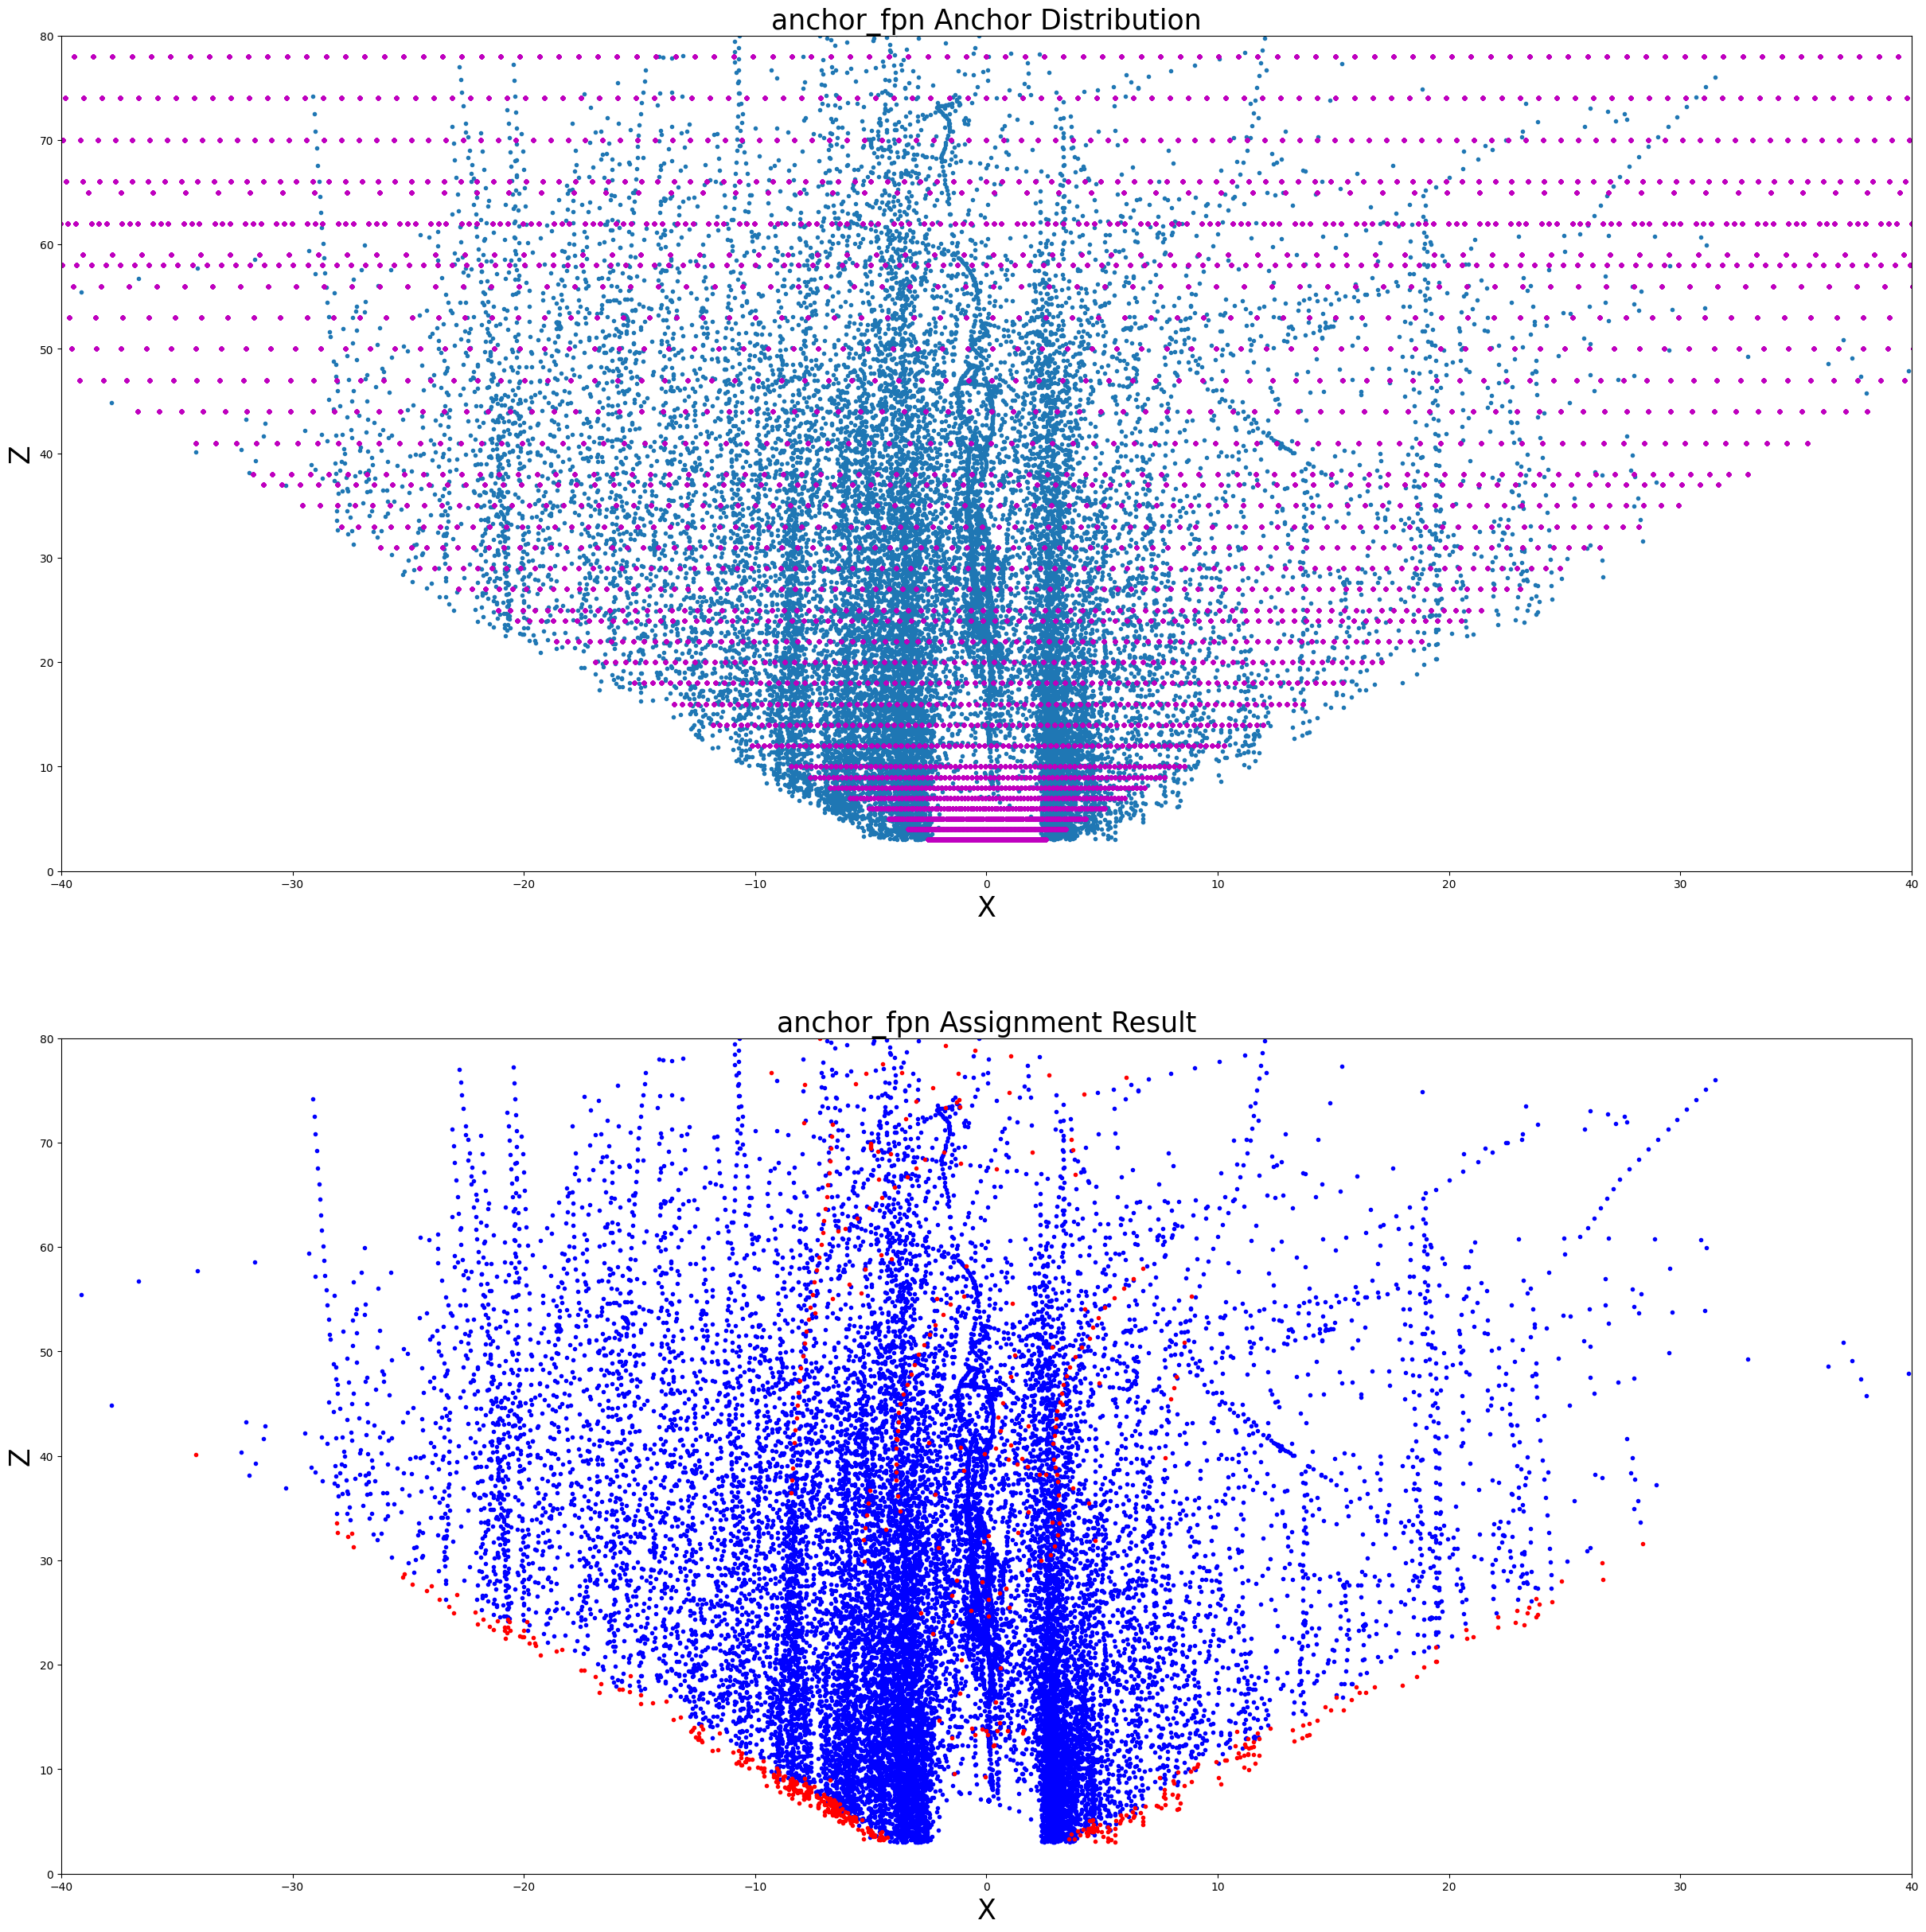

In [5]:
axs = init_xz_plt([f"{ANCHOR_GENERATION_METHOD} Anchor Distribution", f"{ANCHOR_GENERATION_METHOD} Assignment Result"])

# Draw Ground true
axs[0].plot([l.x3d for l in labels_all], [l.z3d for l in labels_all], '.') # Draw ground true

# Draw anchors
axs[0].plot([a.x3d for a in anchors], [a.z3d for a in anchors], '.m',) # Draw filtered GAC anchor

covered_gt_list = []
missed_gt_list = []
for i, assign_list in enumerate(assign_result):
    if len(assign_list) > 0: # Covered gt
        covered_gt_list.append(i)
    else:
        missed_gt_list.append(i)

# Draw Assignemnt result
axs[1].plot([labels_all[i].x3d for i in covered_gt_list], [labels_all[i].z3d for i in covered_gt_list], '.b',)
axs[1].plot([labels_all[i].x3d for i in missed_gt_list], [labels_all[i].z3d for i in missed_gt_list], '.r',)

